In [1]:
%reload_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from tqdm.notebook import tqdm
import pandas as pd

from physics_mi.utils import set_all_seeds

In [3]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 3243091524  # this one is very interesting
# pleasingly_symmetric_seed = 95433229
set_all_seeds(seed)
print(seed)

1461278593


In [158]:
class config:
    POLY_ORDER = 20
    N_FUNCS = 10
    TRAIN_SIZE = 8000
    VALID_SIZE = 2000
    MODELS_PER_FUNC = 50
    MODEL_HIDDEN_DIM = 32

In [172]:
from physics_mi.eval import *


def generate_polynomial(n=20):
    coeffs = np.random.rand(n) * 2 - 1
    return np.polynomial.Polynomial(coeffs)


def plot_funcs(funcs):
    _, axes = plt.subplots(2, 5, figsize=(15, 6))

    x = np.linspace(-1, 1, 100)
    for i, (ax, func) in enumerate(zip(axes.flatten(), funcs)):
        ax.plot(x, func(x))
        ax.set_title(f"Function {i}")


class PolynomialData:
    def __init__(self, func: np.polynomial.Polynomial, size: int) -> None:
        self.func = func
        self.size = size
        self.X = np.random.rand(size) * 2 - 1
        self.Y = self.func(self.X)
        self.torchify_data()

    def torchify_data(self):
        self.X = torch.as_tensor(self.X).float()[:, None]
        self.Y = torch.as_tensor(self.Y).float()[:, None]


def generate_polynomial_data(funcs, train_size, valid_size):
    return [
        {
            "train": PolynomialData(func, train_size),
            "valid": PolynomialData(func, valid_size),
        }
        for func in funcs
    ]


class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)


def get_model():
    return Net(input_dim=1, hidden_dim=config.MODEL_HIDDEN_DIM, output_dim=1)


def train_model(train_data, valid_data):
    N = 100  # number of epochs

    model = Net(input_dim=1, hidden_dim=hidden_dim, output_dim=1)
    loss_func = nn.MSELoss()
    optimiser = Adam(model.parameters(), lr=1e-1)
    log = []

    for i in range(N):
        log_sample = {}

        # Training update
        model.train()
        model.zero_grad()
        Y_hat = model(train_data.X)
        loss = loss_func(Y_hat, train_data.Y)
        log_sample["train_loss"] = float(loss.detach())
        loss.backward()
        optimiser.step()

        # Validation set
        model.eval()
        Y_hat = model(valid_data.X)
        loss = loss_func(Y_hat, valid_data.Y)
        log_sample["valid_loss"] = float(loss.detach())

        log.append(log_sample)

    log = pd.DataFrame(log)

    return model, log


def get_preds(model, valid_data):
    model.eval()

    with torch.inference_mode():
        out = model(valid_data.X)

    y_preds = out.numpy()[:, 0]
    y_targs = valid_data.Y.numpy()[:, 0]

    return y_preds, y_targs


def plot_models(df, data):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for ax, (i, row) in zip(axes.flatten(), df.iterrows()):
        model = get_model()
        model.load_state_dict(row["model"])
        valid_data = data[i]["valid"]

        y_preds, _ = get_preds(model, valid_data)

        sort_idxs = torch.argsort(valid_data.X[:, 0]).numpy()
        x = valid_data.X.numpy()[sort_idxs]
        y = valid_data.Y.numpy()[sort_idxs]
        y_preds_plot = y_preds[sort_idxs]

        ax.scatter(x, y_preds_plot, s=5, label="Predicted", alpha=0.5, color="grey")
        ax.plot(x, y, label="True", color="salmon")

        _ = ax.set_title(f"Function {i}")

In [173]:
funcs = [generate_polynomial(config.POLY_ORDER) for _ in range(config.N_FUNCS)]
data = generate_polynomial_data(
    funcs, train_size=config.TRAIN_SIZE, valid_size=config.VALID_SIZE
)

models = []
for func, func_data in tqdm(zip(funcs, data), total=len(data)):
    model, log = train_model(func_data["train"], func_data["valid"])
    row = {}
    row["func"] = func
    row["model"] = model.state_dict()
    row["valid_loss"] = log["valid_loss"].iloc[-1]
    models.append(row)

mdf = pd.DataFrame(models)

  0%|          | 0/10 [00:00<?, ?it/s]

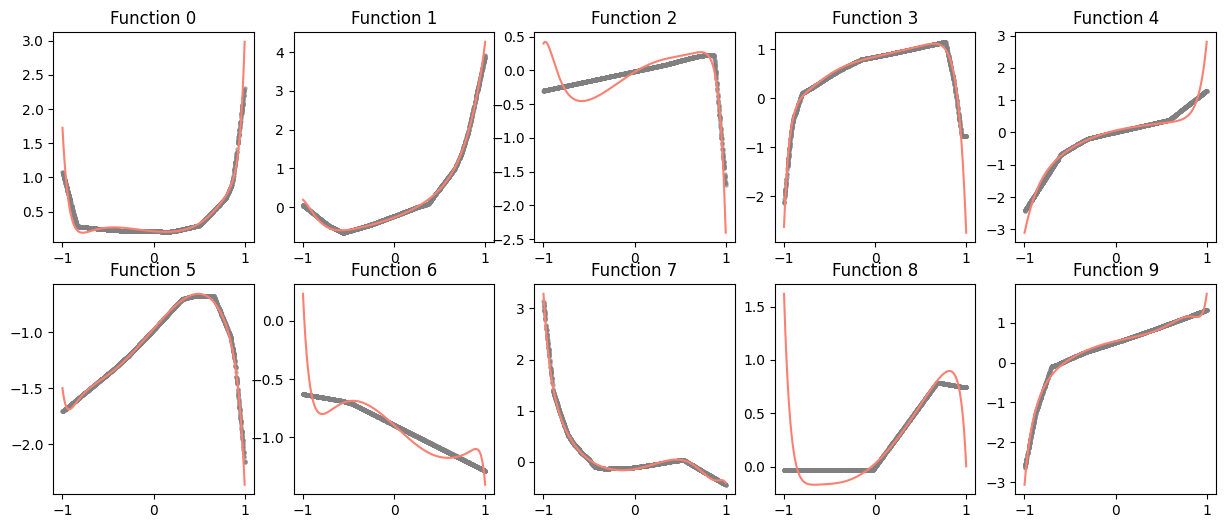

In [174]:
plot_models(mdf, data)